# Demo Colab for Team C1

Members:


## Imports

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch, torchvision
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from PIL import Image
import os
from torch.utils.data import DataLoader, Dataset, random_split

## Data loading & preprocessing

The data acquisition process is omitted for brevity. Instead, 512 (for now) images are used as a sample.

In [ ]:
# get dataset from here:
# https://mega.nz/file/3BAHBSAJ#D18t-GHW3LTkY0M23HUYTDyWPwUHevOGyxQSWRguykI
# put it in the top-level directory of the colab filesystem (i.e. don't put it in a folder).

In [2]:
!unzip -q sample.zip
!rm -rf __MACOSX/

In [32]:
# a slightly simplified version that only loads a local file
class HistopathologicCancerDetectionDataset(Dataset):

    def __init__(self, data_path, csv_data_path):
        self.data_path = data_path
        # self._download() # don't need to download data in this case
        self.train_labels = pd.read_csv(csv_data_path)
        self.transforms = transforms.Compose([transforms.ToTensor()])

    def __len__(self):
        return len(self.train_labels)

    def __getitem__(self, index):
        image_id = self.train_labels["id"].iloc[index]
        label = self.train_labels["label"].iloc[index]
        img = Image.open(os.path.join(self.data_path, "train", image_id + ".tif"))
        return self.transforms(img), label

    def _download(self): # code omitted for brevity
        pass

In [33]:
def load_data(data_path=".", csv_data_path="train_labels.csv", test_split=0.33, batch_size=16):
    dataset = HistopathologicCancerDetectionDataset(data_path, csv_data_path)
    test_size = int(len(dataset) * test_split)
    train_size = len(dataset) - test_size
    train_set, test_set = random_split(dataset, [train_size, test_size])
    train_loader = DataLoader(train_set, shuffle=True, batch_size=batch_size)
    test_loader = DataLoader(test_set, batch_size=batch_size)
    return train_loader, test_loader

In [34]:
train_dataloader, test_data_loader = load_data()

## Other boilerplate

This section initialises other parts of the project, such as `wandb`.

In [ ]:
!pip install wandb

In [12]:
!wandb login

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: ERROR API key must be 40 characters long, yours was 22
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [13]:
import wandb

wandb.init(project="test-project", entity="depressed-people")

wandb: Currently logged in as: sortofamudkip (depressed-people). Use `wandb login --relogin` to force relogin


In [14]:
LEARNING_RATE = 0.001

In [15]:
wandb.config = {
  "learning_rate": LEARNING_RATE,
  "epochs": 100,
  "batch_size": 128
}

## Basic data exploration

torch.Size([16, 3, 96, 96])
---
label: tensor(0)


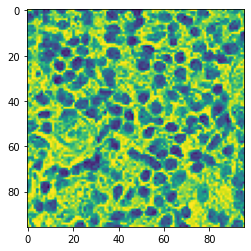

In [35]:
data_iter = iter(train_dataloader)

images, labels = next(data_iter)
print(images.shape)
print("---")
print("label:", labels[0])
plt.imshow(images[0][0]) # first image, first channel (R)

# some statistics from the dataset

## Choosing Hyperparameters

something goes here

## Model(s) initialisation

PROBABLY the final model(s). Need to ask

there's also going to be checkpointing and we're going to explain that here

In [36]:
# disclaimer: this is more or less lenet
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 5x5 square convolution
        # kernel
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(7056, 120)  
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)
        # softmax at the end
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square, you can specify with a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = self.softmax(x)
        return x

net = Net()
print(net)

params = list(net.parameters())
print(len(params))
print(params[0].size())  # conv1's .weight

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=7056, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=2, bias=True)
  (softmax): Softmax(dim=1)
)
10
torch.Size([6, 3, 5, 5])


## Loss Function & Optimiser

In [37]:
criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)

## Training

In [38]:
PRINT_CYCLE = 3

for epoch in range(5):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()

        optimizer.step()

        # log the loss, F1 score, **AUC (ROC thing)**
        wandb.log({"loss": loss})


        # print statistics
        running_loss += loss.item()
        if i % PRINT_CYCLE == (PRINT_CYCLE-1):    # print every few mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / PRINT_CYCLE:.3f}')
            running_loss = 0.0


[1,     3] loss: 0.686
[1,     6] loss: 0.710
[1,     9] loss: 0.691
[1,    12] loss: 0.697
[1,    15] loss: 0.688
[1,    18] loss: 0.691
[1,    21] loss: 0.680
[2,     3] loss: 0.674
[2,     6] loss: 0.632
[2,     9] loss: 0.667
[2,    12] loss: 0.677
[2,    15] loss: 0.654
[2,    18] loss: 0.642
[2,    21] loss: 0.650
[3,     3] loss: 0.580
[3,     6] loss: 0.595
[3,     9] loss: 0.619
[3,    12] loss: 0.545
[3,    15] loss: 0.592
[3,    18] loss: 0.527
[3,    21] loss: 0.604
[4,     3] loss: 0.532
[4,     6] loss: 0.519
[4,     9] loss: 0.531
[4,    12] loss: 0.380
[4,    15] loss: 0.652
[4,    18] loss: 0.522
[4,    21] loss: 0.605
[5,     3] loss: 0.673
[5,     6] loss: 0.628
[5,     9] loss: 0.706
[5,    12] loss: 0.641
[5,    15] loss: 0.609
[5,    18] loss: 0.618
[5,    21] loss: 0.643


## Testing

In [39]:
input = torch.randn(1, 3, 96, 96)
out = net(input)
print(out)

tensor([[1., 0.]], grad_fn=<SoftmaxBackward0>)


In [40]:
correct = 0
total = 0

with torch.no_grad():
    for data in test_data_loader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        print(f"{predicted.numpy()} vs {labels.numpy()}")
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the training images: {100 * correct / total} %')

[1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1] vs [0 0 1 0 0 0 0 1 1 0 0 0 0 1 1 1]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1] vs [0 0 0 0 0 0 0 0 1 0 0 0 1 1 1 0]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1] vs [0 1 0 0 1 0 0 0 1 1 0 1 0 1 0 0]
[1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1] vs [0 1 0 0 0 0 1 1 0 0 1 1 1 1 0 0]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1] vs [1 0 0 1 1 1 1 1 1 0 1 1 1 0 1 1]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1] vs [1 1 0 1 1 1 1 0 1 0 1 0 1 0 0 1]
[1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1] vs [0 0 1 1 1 1 1 1 1 0 1 0 0 0 0 1]
[1 1 1 1 1 0 0 1 1 1 1 0 1 1 1 1] vs [0 1 0 0 1 0 0 1 0 0 0 0 1 0 0 0]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1] vs [1 1 0 1 0 1 1 1 1 0 0 1 1 1 0 1]
[1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1] vs [1 0 1 0 0 1 1 1 1 0 1 1 0 0 0 0]
[1 1 1 1 1 1 1 1] vs [0 0 0 1 1 0 0 0]
Accuracy of the network on the training images: 52.38095238095238 %


## Evaluation

Statistics and visualisation go here

## Analysis